In [1]:
#copy this into the Continuous AP folder after cluster cutting
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sampRate=30000 #figure out how to get around hard coding this
spike_times=np.load('spike_times.npy')
st=spike_times/sampRate
spike_templates=np.load('spike_templates.npy')
spike_clusters=np.load('spike_clusters.npy')
cids=pd.read_table('cluster_info.tsv')
cids.head()

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,0,301.0,101.9,mua,19.176311,1,20.0,10.543538,noise,35886,0
1,1,190.6,106.5,mua,14.127209,15,160.0,6.923255,noise,23564,0
2,2,227.2,99.7,mua,15.683676,15,160.0,9.271944,noise,31558,0
3,3,318.3,inf,mua,14.507984,15,160.0,0.012634,mua,43,0
4,4,170.4,87.9,mua,12.783755,35,360.0,9.511396,noise,32373,0


In [3]:
cids_good=cids.query("group=='good'")
cids_good=cids_good.reset_index(drop=True)
np.shape(cids_good)
good_units=np.array(cids_good['id'])
cids_good.head()

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,13,351.9,0.9,good,21.665257,95,960.0,8.381417,good,28527,0
1,18,252.8,9.3,good,18.677330,123,1240.0,34.779339,good,118375,0
2,20,348.9,8.9,good,26.365196,133,1340.0,10.151307,good,34551,0
3,21,255.6,12.2,mua,19.073395,133,1340.0,18.215119,good,61997,0
4,25,208.7,152.3,mua,12.679985,156,1580.0,1.620930,good,5517,0


In [4]:
histology=pd.read_csv('NP1_electrode_locations.csv')
histology.head()

,upperBorder,lowerBorder,acronym,name,avIndex
0,0,210,VISal2/3,Anterolateral visual area layer 2/3,167
1,210,350,AUDpo2/3,Posterior auditory area layer 2/3,146
2,350,440,AUDpo4,Posterior auditory area layer 4,147
3,440,790,AUDpo5,Posterior auditory area layer 5,148
4,790,980,AUDpo6a,Posterior auditory area layer 6a,149


In [5]:
import warnings
warnings.filterwarnings("ignore")        

s=pd.Series(cids_good['depth'])
top=np.array(histology['upperBorder'])
bottom=np.array(histology['lowerBorder'])
name=histology['acronym']

brain_area=[None]*len(s)
for i in range(len(top)-1):
    isbetween=s.between(top[i],bottom[i], inclusive=True)
    this_ind=s[isbetween].index.values
    
    if len(this_ind)>1:
        for j in range(len(this_ind)-1):
            brain_area[this_ind[j]]=name[i]
    elif len(this_ind)==0:
        this_ind=this_ind
    else:
        this_ind=np.asscalar(this_ind)
        brain_area[this_ind]=name[i]

cids_good.insert(0,'BrainArea', brain_area)
cids_good.head()

,BrainArea,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,AUDpo6a,13,351.9,0.9,good,21.665257,95,960.0,8.381417,good,28527,0
1,alv,18,252.8,9.3,good,18.677330,123,1240.0,34.779339,good,118375,0
2,CA1,20,348.9,8.9,good,26.365196,133,1340.0,10.151307,good,34551,0
3,CA1,21,255.6,12.2,mua,19.073395,133,1340.0,18.215119,good,61997,0
4,CA1,25,208.7,152.3,mua,12.679985,156,1580.0,1.620930,good,5517,0


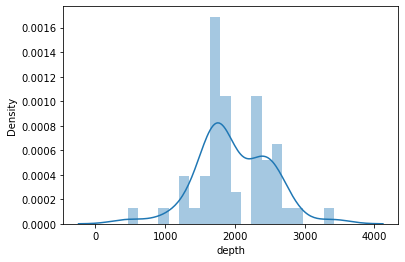

In [6]:
ax=sns.distplot(cids_good['depth'],bins=20)
plt.savefig('numcells_alongprobe.svg')

In [30]:
cids_good.groupby('BrainArea').count()

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
BrainArea,,,,,,,,,,,
AUDpo5,1,1,1,1,1,1,1,1,1,1,1
AUDpo6a,1,1,1,1,1,1,1,1,1,1,1
CA1,27,27,27,27,27,27,27,27,27,27,27
CA2,1,1,1,1,1,1,1,1,1,1,1
CA3,19,19,19,19,19,19,19,19,19,19,19
alv,1,1,1,1,1,1,1,1,1,1,1


In [7]:
#load in events
cwd=os.getcwd()
from os.path import dirname as up

abs_path = up(up(up(cwd)))


events=np.load((os.path.join(abs_path,r'events\Neuropix-PXI-slot2-probe1\TTL_1\event_timestamps.npy')))
events=events/(sampRate/100)
print(events[-1])

281116.4266666667


In [8]:
#make a dataframe out of spiketimes and cluster ids
st = np.array(st).flatten()
spikes=pd.DataFrame()
spikes['Spike Times']=st.tolist()
spikes['Cluster ID']=spike_clusters.tolist()

good_spikes=spikes.loc[spikes['Cluster ID'].isin(good_units)]
good_spikes=good_spikes.sort_values(by=['Cluster ID'])
good_spikes.head()

,Spike Times,Cluster ID
582652,619.597167,13
1190831,1408.743667,13
480210,499.524100,13
1377917,1697.611933,13
1566803,2016.441067,13


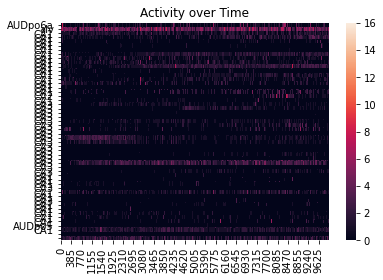

In [9]:
#for heatmap visualization- 100 ms bins
import elephant.conversion as conv
import neo as n
import quantities as pq
    
num_cells=np.unique(good_spikes['Cluster ID'])
spike_matrix=[]

import warnings
warnings.filterwarnings("ignore")

for i in range(len(num_cells)):
    this_cell_ind=good_spikes['Cluster ID']==num_cells[i]
    this_cell=good_spikes[this_cell_ind]
    this_cell=this_cell.sort_values('Spike Times')
    spike_times=this_cell['Spike Times']
    a = n.SpikeTrain([spike_times] * pq.s,
                 t_stop=round(max(good_spikes['Spike Times'])) * pq.s)
    x = conv.BinnedSpikeTrain(a, n_bins=round(max(good_spikes['Spike Times']))*10, bin_size=.1 * pq.s,
                          t_start=0 * pq.s)
    x=(x.to_array())
    x=x.flatten()
    spike_matrix.append(x)

spike_matrix=np.array(spike_matrix)


#heatmap spikes from all neurons
ax=sns.heatmap(spike_matrix[:,1:10000], yticklabels=cids_good['BrainArea'])
plt.title('Activity over Time')
plt.savefig('basline_activity.svg')

In [ ]:
plt.subplots(figsize=(5,10))
#heatmap spikes from all neurons
ax=sns.heatmap(spike_matrix[:,1:10000], yticklabels=cids_good['BrainArea'])
plt.title('Activity over Time')
plt.savefig('baseline_activity.svg')

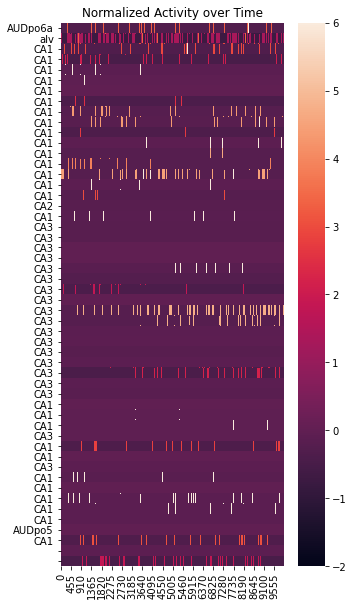

In [11]:
#normalized heatmap, all time bins
from scipy import stats

spike_matrix_norm=stats.zscore(spike_matrix,axis=1)
#print(spike_matrix_norm[-5:-1,0:99])
plt.subplots(figsize=(5,10))

ax2=sns.heatmap(spike_matrix_norm[:,1:10000], yticklabels=cids_good['BrainArea'], vmin=-2, vmax=6)
plt.title('Normalized Activity over Time')
plt.savefig('baseline_activity_norm.svg')

In [12]:
##Change spikes matrix to line up with events (10 ms bins)
num_cells=np.unique(good_spikes['Cluster ID'])
spike_matrix=[]

import warnings
warnings.filterwarnings("ignore")

for i in range(len(num_cells)):
    this_cell_ind=good_spikes['Cluster ID']==num_cells[i]
    this_cell=good_spikes[this_cell_ind]
    this_cell=this_cell.sort_values('Spike Times')
    spike_times=this_cell['Spike Times']
    a = n.SpikeTrain([spike_times] * pq.s,
                 t_stop=round(max(good_spikes['Spike Times'])) * pq.s)
    x = conv.BinnedSpikeTrain(a, n_bins=round(max(good_spikes['Spike Times']))*100, bin_size=.01 * pq.s,
                          t_start=0 * pq.s)
    x=(x.to_array())
    x=x.flatten()
    spike_matrix.append(x)

spike_matrix=np.array(spike_matrix)
spike_matrix_norm=stats.zscore(spike_matrix,axis=1)

In [ ]:
spike_matrix_norm.shape

In [13]:
#baseline is 0 through events[0]
#switches between stim are ~120 seconds apart, pure tones 
delt_events=np.round(np.diff(events),2)

#print(event_ts[0:50])
np.shape(delt_events)

stim_break=delt_events>2000
break_inds=np.where(stim_break)[0] #in my case there should be 3 unless the notes specify otherwise
print(break_inds)

[279 519 799]


In [31]:
#pure tones- 1st and 3rd
pt1=events[0:break_inds[0]-1];pt1_start=np.round(pt1[::2]); pt1_start=pt1_start.astype(int)
pt1_end=np.round(pt1[1::2]); pt1_end=pt1_end.astype(int)
pt2=events[break_inds[1]-1:break_inds[2]-1]; pt2_start=np.round(pt2[::2]); pt2_start=pt2_start.astype(int)
pt2_end=np.round(pt2[1::2]);pt2_end=pt2_end.astype(int)

In [32]:
## train on the first set of pure tone stimuli

tones=[64000,4000,16000,32000,11314,45255,8000,5657,9514,19027,22627] #tone freqs
pt_start=pt1_start
pt_end=pt1_end

##make a repeating label vector
num_reps=np.ceil(len(pt_start)/len(tones)).astype(int)
tone_labels=np.tile(tones, num_reps)
tone_labels=tone_labels[:len(pt1_start)]

In [35]:
max(stim_labels)

64000.0

In [34]:
##make label vector

stim_labels=np.zeros(len(spike_matrix[1]))
for i in range(len(pt_start-1)):
    stim_labels[pt_start[i]:pt_end[i]]=tone_labels[i]


In [36]:
##the times with no stim will overwhelm this, remove them
stim_labels_t=stim_labels[np.where(stim_labels>0)]
spike_matrix_t=spike_matrix_norm[:,np.where(stim_labels>0)]
spike_matrix_t=spike_matrix_t.reshape(len(num_cells),len(stim_labels_t))
spike_matrix_t.shape

(52, 695)

In [60]:
#make pure tone tuning curve for each cell
mean_activity=np.zeros((len(spike_matrix_t),len(tones)-1))
ste=np.zeros((len(spike_matrix_t),len(tones)-1))

for i in range(len(tones)-1):
    a=np.mean(spike_matrix_t[:,np.where(stim_labels_t==tones[i])],axis=2)
    mean_activity[:,i]=a.reshape(len(num_cells))
    b=stats.sem(spike_matrix_t[:,np.where(stim_labels_t==tones[i])],axis=2)
    ste[:,i]=b.reshape(len(num_cells))
    

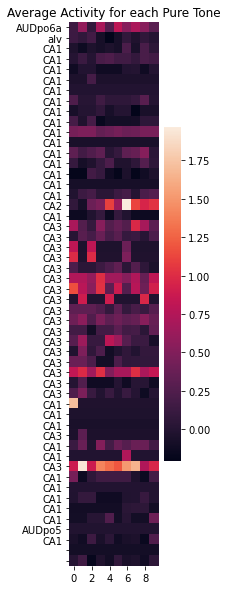

In [38]:
plt.subplots(figsize=(2,10))

sns.heatmap(mean_activity, yticklabels=cids_good['BrainArea'])
plt.title('Average Activity for each Pure Tone')
plt.savefig('PuretoneHeatMap.svg')

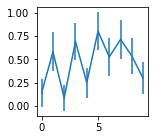

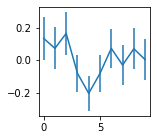

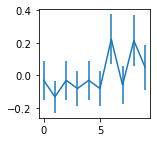

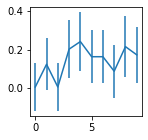

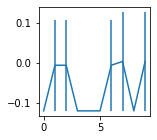

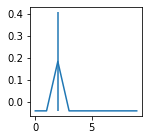

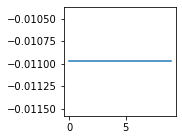

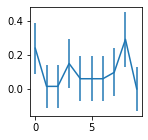

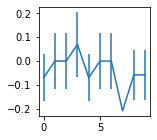

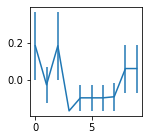

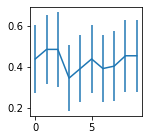

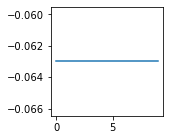

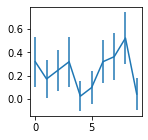

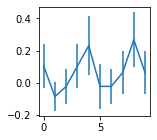

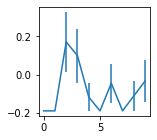

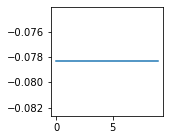

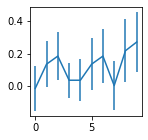

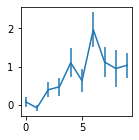

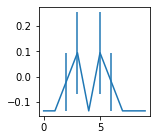

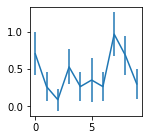

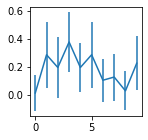

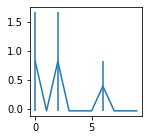

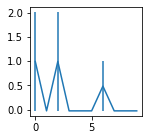

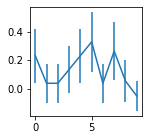

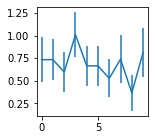

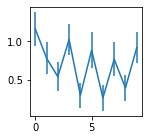

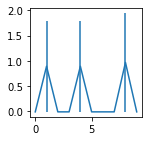

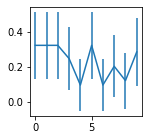

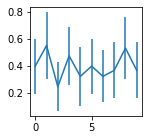

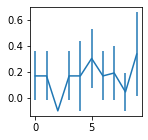

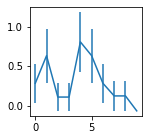

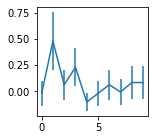

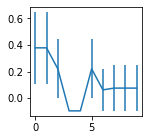

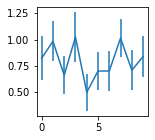

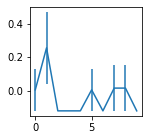

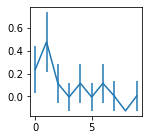

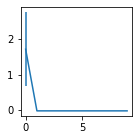

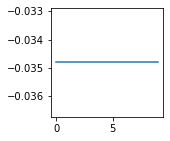

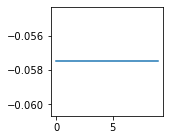

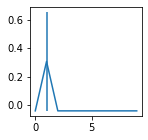

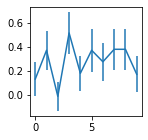

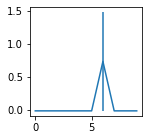

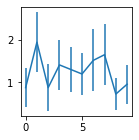

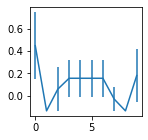

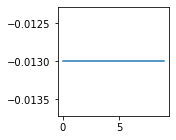

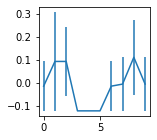

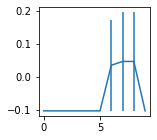

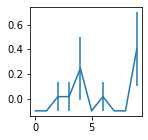

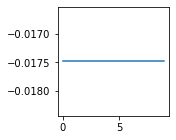

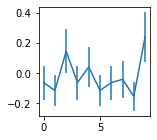

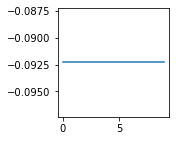

In [61]:
x=np.arange(len(tones)-1)
for i in range(len(num_cells)-1):
    plt.subplots(figsize=(2,2))
    plt.errorbar(x,mean_activity[i,:],yerr=ste[i,:])

In [22]:
##pup calls- 2nd and 4th
## these are actually played 1500 ms after the TTL for some reason
pc1=events[break_inds[0]-1:break_inds[1]-1];pc1_start=np.round(pc1[::2]); pc1_start=pc1_start.astype(int)+15000
pc1_end=np.round(pc1[1::2]); pc1_end=pc1_end.astype(int)+15000
pc2=events[break_inds[2]-1:-1]; pc2_start=np.round(pc2[::2]); pc2_start=pc2_start.astype(int)+15000
pc2_end=np.round(pc2[1::2]);pc2_end=pc2_end.astype(int)+15000

pt_start=pc1_start
pt_end=pc1_end

calls=[1,2,3,4,5]

##make a repeating label vector
num_reps=np.ceil(len(pt_start)/len(calls)).astype(int)
call_labels=np.tile(calls, num_reps)
call_labels=call_labels[:len(pt1_start)]


stim_labels=np.zeros(len(spike_matrix[0]))
for i in range(len(pt_start-1)):
    stim_labels[pt_start[i]:pt_end[i]]=call_labels[i]

    
stim_labels_t=stim_labels[np.where(stim_labels>0)]
spike_matrix_t=spike_matrix_norm[:,np.where(stim_labels>0)]
spike_matrix_t=spike_matrix_t.reshape(len(num_cells),len(stim_labels_t))
spike_matrix_t.shape

(52, 600)

In [23]:
mean_activity=np.zeros((len(spike_matrix_t),len(calls)-1))
std=np.zeros((len(spike_matrix_t),len(calls)-1))

for i in range(len(calls)-1):
    a=np.mean(spike_matrix_t[:,np.where(stim_labels_t==calls[i])],axis=2)
    mean_activity[:,i]=a.reshape(len(num_cells))
    b=np.std(spike_matrix_t[:,np.where(stim_labels_t==calls[i])],axis=2)
    std[:,i]=b.reshape(len(num_cells))
    

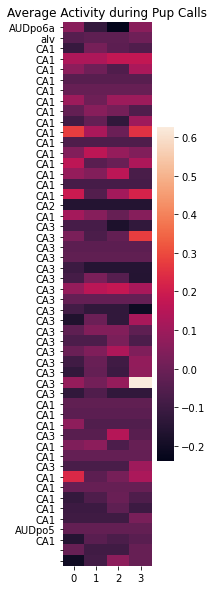

In [24]:
plt.subplots(figsize=(2,10))

sns.heatmap(mean_activity, yticklabels=cids_good['BrainArea'])
plt.title('Average Activity during Pup Calls')
plt.savefig('ActivityduringPupCalls.svg')

In [ ]:
#train a classifier
from sklearn import svm
clf = svm.SVC(kernel='linear',
            decision_function_shape='ovo',
            class_weight='balanced')

clf.fit(spike_matrix_noITI,stim_labels_noITI)

In [ ]:
#compute training performance and return indices of the support vectors
train_labels=clf.predict(spike_matrix_noITI)

same_inds = [index for index, elem in enumerate(stim_labels_noITI) 
                           if elem != train_labels[index]] 
percentCorrect=len(same_inds)/len(train_labels)

print('PercentCorrectTrain...', percentCorrect*100)

In [ ]:
#compute performance on held out data
pt2=events[break_inds[1]-1:break_inds[2]-1]; pt2_start=np.round(pt2[::2]); pt2_start=pt2_start.astype(int)
pt2_end=np.round(pt2[1::2]);pt2_end=pt2_end.astype(int)
pt_start=pt2_start
pt_end=pt2_end

##make a repeating label vector

num_reps=np.ceil(len(pt_start)/len(tones)).astype(int)
tone_labels=np.tile(tones, num_reps)
tone_labels=tone_labels[:len(pt_start)]
stim_labels_test=np.zeros(len(spike_matrix[0]))
for i in range(len(pt_start-1)):
    stim_labels_test[pt_start[i]:pt_end[i]]=tone_labels[i]
    
stim_labels_test_noITI=stim_labels_test[np.where(stim_labels>0)]
spike_matrix_test_noITI=spike_matrix[:,np.where(stim_labels>0)]
spike_matrix_test_noITI=spike_matrix_test_noITI.reshape(len(stim_labels_test_noITI),len(num_cells))

In [ ]:
test_labels=clf.predict(spike_matrix_test_noITI)

same_inds_test = [index for index, elem in enumerate(stim_labels_test_noITI) 
                           if elem != test_labels[index]] 
percentCorrecttest=len(same_inds_test)/len(test_labels)

In [ ]:
print('PercentCorrectTest...', percentCorrecttest*100)

In [ ]:
def create_shuffle_evs_matrix(evs_matrix, bool_filter=None, traces=False, conv_func=None):
    
    if bool_filter is None:
        bool_filter = [True] * evs_matrix.shape[0]
    
    evs_matrix_sh = evs_matrix.copy()

    for cell in range(evs_matrix.shape[1]):
        evs_matrix_sh[:, cell][bool_filter] = np.random.permutation(evs_matrix[:, cell][bool_filter])
    
    if traces:
        
        if conv_func is None:
            conv_func = np.roll(ut.exp2kernel(5.1, 5, 1000), 500)
        traces_sh = evs_matrix_sh.copy()
        for cell in xrange(evs_matrix.shape[1]):
            traces_sh[:, cell] = np.convolve(traces_sh[:, cell], exp_func/exp_func.sum(), mode='same')
        toret = traces_sh
    
    else:
        toret = evs_matrix_sh
        
    return toret  
spike_mat_shuffle=create_shuffle_evs_matrix(spike_matrix_test_noITI)

In [ ]:
chance_labels=clf.predict(spike_mat_shuffle)

same_inds_chance = [index for index, elem in enumerate(stim_labels_test_noITI) 
                           if elem != chance_labels[index]] 
percentCorrectchance=len(same_inds_chance)/len(chance_labels)

In [ ]:
print('PercentCorrectChance...', percentCorrectchance*100)

In [ ]:
clf.n_support_

In [ ]:
from __future__ import division

def compute_sta(stim, rho, num_timesteps):
    sta = np.zeros((num_timesteps,))

    spike_times = rho[num_timesteps:].nonzero()[0] + num_timesteps
    #print(spike_times)
    #print(rho[num_timesteps:].nonzero()[0])
    num_spikes = len(spike_times)

    print("Number of spikes: ", num_spikes)
    
    for a_spikeIdx in spike_times:
        sta += stim[a_spikeIdx-num_timesteps:a_spikeIdx]

    sta /= num_spikes


    return sta

In [ ]:
sta=compute_sta(stim_labels,spike_matrix[1,:],100)

In [ ]:
sns.lineplot(sta)

In [ ]:
##compute tuning
def compute_tuning(stim_set,)
